<a href="https://colab.research.google.com/github/JYoung998/Quant-Projects/blob/main/Order_Book_Imbalance_Alpha_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

np.random.seed(42)

print("Libraries imported, pandas display options set, and random seed initialized.")

Libraries imported, pandas display options set, and random seed initialized.


In [49]:
def load_lob(path):
    """
    Loads Limit Order Book (LOB) data from a CSV, parses timestamps,
    sorts by timestamp, and drops invalid rows.

    Args:
        path (str): The file path to the LOB CSV data.

    Returns:
        pd.DataFrame: The processed LOB data.
    """
    print(f"Loading data from: {path}")
    try:
        df = pd.read_csv(path)
    except FileNotFoundError:
        print(f"Error: File not found at {path}. Please ensure the file exists and the path is correct.")
        return None

    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df = df.sort_values(by='timestamp').reset_index(drop=True)
    else:
        print("Warning: 'timestamp' column not found. Skipping timestamp conversion and sorting.")

    original_rows = df.shape[0]
    df.dropna(inplace=True)
    rows_after_drop = df.shape[0]
    if original_rows > rows_after_drop:
        print(f"Dropped {original_rows - rows_after_drop} rows with NaN values.")

    return df

# NOTE: Replace 'path/to/your/lob_data.csv' with the actual path to your LOB data file.
# For demonstration, we'll create a dummy CSV if the file doesn't exist.
lob_data_path = 'lob_data.csv'

# Create a dummy CSV for demonstration if it doesn't exist
try:
    with open(lob_data_path, 'x') as f:
        f.write('timestamp,bid_price_1,bid_volume_1,ask_price_1,ask_volume_1,mid_price\n')
        f.write('2023-01-01 09:00:00.000,100.0,100,100.1,50,100.05\n')
        f.write('2023-01-01 09:00:00.001,100.0,90,100.1,60,100.05\n')
        f.write('2023-01-01 09:00:00.002,100.0,110,100.1,40,100.05\n')
        f.write('2023-01-01 09:00:00.003,100.1,80,100.2,70,100.15\n')
        f.write('2023-01-01 09:00:00.004,100.1,70,100.2,80,100.15\n')
        f.write('2023-01-01 09:00:00.005,100.1,60,100.2,90,100.15\n')
        f.write('2023-01-01 09:00:00.006,100.2,50,100.3,100,100.25\n')
        f.write('2023-01-01 09:00:00.007,100.2,40,100.3,110,100.25\n')
        f.write('2023-01-01 09:00:00.008,100.3,30,100.4,120,100.35\n')
        f.write('2023-01-01 09:00:00.009,100.3,20,100.4,130,100.35\n')
except FileExistsError:
    pass # File already exists


lob_df = load_lob(lob_data_path)

if lob_df is not None:
    print("\n--- DataFrame Head ---")
    print(lob_df.head())

    print("\n--- DataFrame Info ---")
    lob_df.info()

    print("\n--- Basic Data Checks ---")
    print(f"DataFrame Shape: {lob_df.shape}")
    print("\nNull values per column:")
    print(lob_df.isnull().sum())
    print("\nDescriptive Statistics:")
    print(lob_df.describe())


Loading data from: lob_data.csv

--- DataFrame Head ---
                timestamp  bid_price_1  bid_volume_1  ask_price_1  \
0 2023-01-01 09:00:00.000        100.0           100        100.1   
1 2023-01-01 09:00:00.001        100.0            90        100.1   
2 2023-01-01 09:00:00.002        100.0           110        100.1   
3 2023-01-01 09:00:00.003        100.1            80        100.2   
4 2023-01-01 09:00:00.004        100.1            70        100.2   

   ask_volume_1  mid_price  
0            50     100.05  
1            60     100.05  
2            40     100.05  
3            70     100.15  
4            80     100.15  

--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     10 non-null     datetime64[ns]
 1   bid_price_1   10 non-null     float64       
 2   bid_volume_1  10 non-null

In [50]:
def build_features(df):
    """
    Computes various microstructural features from LOB data.

    Args:
        df (pd.DataFrame): The input LOB DataFrame with 'bid_price_1', 'ask_price_1',
                           'bid_volume_1', 'ask_volume_1', and 'mid_price' columns.

    Returns:
        tuple: A tuple containing:
            - X (pd.DataFrame): DataFrame of engineered features.
            - mid_price_series (pd.Series): The mid-price series.
    """
    features_df = pd.DataFrame(index=df.index)

    # 1. Mid-Price (if not already accurately calculated, recalculate)
    # Assuming mid_price is already present and correct from previous steps, or re-calculate for consistency.
    features_df['mid_price_calculated'] = (df['bid_price_1'] + df['ask_price_1']) / 2
    # Use the existing 'mid_price' column from the input dataframe as the base for other calculations
    # or use 'mid_price_calculated' if the input did not have it.
    mid_price_series = df['mid_price'] if 'mid_price' in df.columns else features_df['mid_price_calculated']

    # 2. Spread
    features_df['spread'] = df['ask_price_1'] - df['bid_price_1']

    # 3. Relative Spread
    features_df['relative_spread'] = features_df['spread'] / mid_price_series

    # 4. Top-of-Book Imbalance (OBI)
    features_df['top_of_book_imbalance'] = (df['bid_volume_1'] - df['ask_volume_1']) / (df['bid_volume_1'] + df['ask_volume_1'])

    # 5. Depth Totals (Acknowledged limitations for current dummy data)
    # For this dummy dataset, we only have level 1 bid/ask.
    # In a real scenario, this would involve summing volumes across multiple levels.
    features_df['total_volume_1'] = df['bid_volume_1'] + df['ask_volume_1']
    print("Note: Depth totals are limited to Level 1 volumes due to dummy data structure.")

    # 6. Rolling Returns
    # Calculate raw returns first
    price_returns = mid_price_series.pct_change()
    # Using a window of 5 periods for rolling calculations
    features_df['rolling_returns_5'] = price_returns.rolling(window=5).mean()

    # 7. Rolling Volatility
    features_df['rolling_volatility_5'] = price_returns.rolling(window=5).std()

    # 8. Trade Intensity (Acknowledged inability to calculate)
    print("Note: Trade intensity cannot be calculated with current LOB snapshot data (requires actual trade data).")

    # Handle NaN values resulting from rolling calculations (e.g., first few rows)
    # Dropping rows with NaN values for simplicity, as they are often initial window values.
    features_df.dropna(inplace=True)
    mid_price_series = mid_price_series.loc[features_df.index] # Align mid_price with features_df index

    print(f"Original mid_price_series shape: {df['mid_price'].shape}")
    print(f"Processed mid_price_series shape: {mid_price_series.shape}")
    print(f"Features DataFrame shape: {features_df.shape}")

    return features_df, mid_price_series

# Call the function with lob_df
features_df, mid_price_series = build_features(lob_df)

print("\n--- Engineered Features DataFrame Head ---")
print(features_df.head())

print("\n--- Mid Price Series Head (aligned with features) ---")
print(mid_price_series.head())

Note: Depth totals are limited to Level 1 volumes due to dummy data structure.
Note: Trade intensity cannot be calculated with current LOB snapshot data (requires actual trade data).
Original mid_price_series shape: (10,)
Processed mid_price_series shape: (5,)
Features DataFrame shape: (5, 7)

--- Engineered Features DataFrame Head ---
   mid_price_calculated  spread  relative_spread  top_of_book_imbalance  \
5                100.15     0.1         0.000999              -0.200000   
6                100.25     0.1         0.000998              -0.333333   
7                100.25     0.1         0.000998              -0.466667   
8                100.35     0.1         0.000997              -0.600000   
9                100.35     0.1         0.000997              -0.733333   

   total_volume_1  rolling_returns_5  rolling_volatility_5  
5             150           0.000200              0.000447  
6             150           0.000400              0.000547  
7             150           

In [51]:
def make_labels(mid, horizon=5, threshold=0.00002):
    """
    Computes future returns and generates labels for price movements.

    Args:
        mid (pd.Series): Series of mid-prices.
        horizon (int): Number of periods into the future to look for price movement.
        threshold (float): The minimum relative price change to be considered an 'up' or 'down' movement.

    Returns:
        pd.Series: A series of labels (+1 for up, -1 for down, 0 for flat), aligned with the input mid-prices.
    """
    # Calculate future mid-price
    future_mid_price = mid.shift(-horizon)

    # Compute future return
    future_return = (future_mid_price - mid) / mid

    # Initialize labels series with NaNs
    labels = pd.Series(index=mid.index, dtype=int)

    # Assign labels based on threshold
    labels[future_return > threshold] = 1
    labels[future_return < -threshold] = -1
    labels[(future_return >= -threshold) & (future_return <= threshold)] = 0

    # Handle rows without sufficient future data (NaNs from shifting are automatically handled by the above assignments)
    # The remaining NaNs will be for the last 'horizon' rows where future_return is NaN.
    # These NaNs are intentionally kept as they represent data points for which we cannot determine a future label.

    print(f"Generated labels for {len(labels.dropna())} out of {len(labels)} data points.")
    return labels

# Call the make_labels function
# Ensure mid_price_series is aligned with features_df before generating labels
# The mid_price_series was already aligned in the previous step.
labels = make_labels(mid=mid_price_series, horizon=2, threshold=0.00002) # Using a smaller horizon for dummy data

print("\n--- Labels Distribution ---")
print(labels.value_counts(dropna=False)) # Include NaN counts

Generated labels for 3 out of 5 data points.

--- Labels Distribution ---
1.0    3
NaN    2
Name: count, dtype: int64


In [52]:
print("Starting train/test split...")

# 1. Align features_df and labels by dropping rows where labels are NaN
aligned_data = features_df.copy()
aligned_data['labels'] = labels

aligned_data.dropna(subset=['labels'], inplace=True)

X_cleaned = aligned_data.drop(columns=['labels'])
y_cleaned = aligned_data['labels']

print(f"Shape of X_cleaned after dropping NaN labels: {X_cleaned.shape}")
print(f"Shape of y_cleaned after dropping NaN labels: {y_cleaned.shape}")

# 2. Determine the size of the training set (e.g., 80%)
train_ratio = 0.8
split_index = int(len(X_cleaned) * train_ratio)

print(f"Split index for {train_ratio*100}% training data: {split_index}")

# 3. Split X_cleaned into X_train and X_test chronologically
X_train = X_cleaned.iloc[:split_index]
X_test = X_cleaned.iloc[split_index:]

# 4. Split y_cleaned into y_train and y_test chronologically
y_train = y_cleaned.iloc[:split_index]
y_test = y_cleaned.iloc[split_index:]

# 5. Print the shapes of the resulting datasets
print("\n--- Shapes of training and testing sets ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

print("Train/test split completed.")

Starting train/test split...
Shape of X_cleaned after dropping NaN labels: (3, 7)
Shape of y_cleaned after dropping NaN labels: (3,)
Split index for 80.0% training data: 2

--- Shapes of training and testing sets ---
X_train shape: (2, 7)
X_test shape: (1, 7)
y_train shape: (2,)
y_test shape: (1,)
Train/test split completed.


In [53]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

print("--- Model Training and Evaluation ---")

# Due to the extremely small dataset size (X_train: 2 samples, X_test: 1 sample),
# many of the evaluation metrics (especially precision, recall, and confusion matrix)
# will not be meaningful or may raise warnings/errors. We proceed for demonstration purposes.
print("\nWARNING: The dataset is extremely small. Evaluation metrics and model performance may not be reliable.")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# 1. Standardize features
print("\n1. Standardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully.")

# Convert scaled arrays back to DataFrames with original column names for better readability
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

# 2. Majority Baseline Model
print("\n2. Training Majority Baseline Model...")
majority_class = y_train.mode()[0]
y_pred_baseline = np.full_like(y_test, majority_class)

# Ensure y_test is a flat array for metrics if it's a Series with a single value
y_test_array = y_test.values.flatten() if isinstance(y_test, pd.Series) else y_test.flatten()
y_pred_baseline_array = y_pred_baseline.flatten() if isinstance(y_pred_baseline, pd.Series) else y_pred_baseline.flatten()

accuracy_baseline = accuracy_score(y_test_array, y_pred_baseline_array)
# Precision and recall might not be well-defined for a single class in y_test.
# Use 'zero_division=0' to handle cases where no positive samples are predicted or present.
precision_baseline = precision_score(y_test_array, y_pred_baseline_array, average='weighted', zero_division=0)
recall_baseline = recall_score(y_test_array, y_pred_baseline_array, average='weighted', zero_division=0)

print(f"  Majority Class: {majority_class}")
print(f"  Baseline Accuracy: {accuracy_baseline:.4f}")
print(f"  Baseline Precision: {precision_baseline:.4f}")
print(f"  Baseline Recall: {recall_baseline:.4f}")

# Determine unique classes in y_train for model training checks
unique_classes_in_train = y_train.nunique()

# 3. Logistic Regression Model
print("\n3. Training Logistic Regression Model...")
if unique_classes_in_train < 2:
    print(f"  Skipping Logistic Regression training: y_train contains only {unique_classes_in_train} unique class(es). Cannot train a multi-class classifier.")
    y_pred_log_reg = np.full_like(y_test_array, majority_class) # Fallback to majority class prediction
    accuracy_log_reg = accuracy_score(y_test_array, y_pred_log_reg)
    precision_log_reg = precision_score(y_test_array, y_pred_log_reg, average='weighted', zero_division=0)
    recall_log_reg = recall_score(y_test_array, y_pred_log_reg, average='weighted', zero_division=0)
    print(f"  (Fallback) Logistic Regression Accuracy: {accuracy_log_reg:.4f}")
    print(f"  (Fallback) Logistic Regression Precision: {precision_log_reg:.4f}")
    print(f"  (Fallback) Logistic Regression Recall: {recall_log_reg:.4f}")
    print("  (Fallback) Classification Report for Logistic Regression:")
    print(classification_report(y_test_array, y_pred_log_reg, zero_division=0))
else:
    log_reg = LogisticRegression(random_state=42, solver='liblinear', multi_class='auto')
    log_reg.fit(X_train_scaled_df, y_train)
    y_pred_log_reg = log_reg.predict(X_test_scaled_df)

    accuracy_log_reg = accuracy_score(y_test_array, y_pred_log_reg)
    precision_log_reg = precision_score(y_test_array, y_pred_log_reg, average='weighted', zero_division=0)
    recall_log_reg = recall_score(y_test_array, y_pred_log_reg, average='weighted', zero_division=0)

    print(f"  Logistic Regression Accuracy: {accuracy_log_reg:.4f}")
    print(f"  Logistic Regression Precision: {precision_log_reg:.4f}")
    print(f"  Logistic Regression Recall: {recall_log_reg:.4f}")
    print("  Classification Report for Logistic Regression:\n", classification_report(y_test_array, y_pred_log_reg, zero_division=0))

    # Plot Confusion Matrix for Logistic Regression
    fig, ax = plt.subplots(figsize=(6, 6))
    ConfusionMatrixDisplay.from_estimator(log_reg, X_test_scaled_df, y_test_array, ax=ax, cmap=plt.cm.Blues)
    ax.set_title('Logistic Regression Confusion Matrix')
    plt.show()

    # Feature Importances (Coefficients) for Logistic Regression
    print("\n  Logistic Regression Coefficients (Feature Importances):")
    if len(log_reg.coef_.shape) > 1: # For multi-class, it's an array of arrays
        # If all classes are the same in y_train, it might train only one class.
        # Handle this case by checking if coef_ has only one row.
        if log_reg.coef_.shape[0] == 1:
            feature_importances_log_reg = pd.Series(log_reg.coef_[0], index=X_train.columns)
        else:
            # For true multi-class, consider displaying per class or mean absolute coefficients
            feature_importances_log_reg = pd.Series(np.mean(np.abs(log_reg.coef_), axis=0), index=X_train.columns)
    else:
        feature_importances_log_reg = pd.Series(log_reg.coef_, index=X_train.columns)
    print(feature_importances_log_reg.sort_values(ascending=False))

# 4. Random Forest Classifier Model
print("\n4. Training Random Forest Classifier Model...")
if unique_classes_in_train < 2:
    print(f"  Skipping Random Forest training: y_train contains only {unique_classes_in_train} unique class(es). Cannot train a multi-class classifier.")
    y_pred_rf = np.full_like(y_test_array, majority_class) # Fallback to majority class prediction
    accuracy_rf = accuracy_score(y_test_array, y_pred_rf)
    precision_rf = precision_score(y_test_array, y_pred_rf, average='weighted', zero_division=0)
    recall_rf = recall_score(y_test_array, y_pred_rf, average='weighted', zero_division=0)
    print(f"  (Fallback) Random Forest Accuracy: {accuracy_rf:.4f}")
    print(f"  (Fallback) Random Forest Precision: {precision_rf:.4f}")
    print(f"  (Fallback) Random Forest Recall: {recall_rf:.4f}")
    print("  (Fallback) Classification Report for Random Forest:")
    print(classification_report(y_test_array, y_pred_rf, zero_division=0))
else:
    # For extremely small datasets, n_estimators might need to be small.
    # Also, min_samples_leaf, min_samples_split might need adjustment.
    # With only 2 samples in X_train, `n_estimators=100` is overkill but kept for consistency.
    # Setting max_depth to a small value or 1 to avoid overfitting to 2 samples.
    rf_clf = RandomForestClassifier(n_estimators=10, random_state=42, max_depth=1, min_samples_leaf=1)
    rf_clf.fit(X_train_scaled_df, y_train)
    y_pred_rf = rf_clf.predict(X_test_scaled_df)

    accuracy_rf = accuracy_score(y_test_array, y_pred_rf)
    precision_rf = precision_score(y_test_array, y_pred_rf, average='weighted', zero_division=0)
    recall_rf = recall_score(y_test_array, y_pred_rf, average='weighted', zero_division=0)

    print(f"  Random Forest Accuracy: {accuracy_rf:.4f}")
    print(f"  Random Forest Precision: {precision_rf:.4f}")
    print(f"  Random Forest Recall: {recall_rf:.4f}")
    print("  Classification Report for Random Forest:\n", classification_report(y_test_array, y_pred_rf, zero_division=0))

    # Plot Confusion Matrix for Random Forest
    fig, ax = plt.subplots(figsize=(6, 6))
    ConfusionMatrixDisplay.from_estimator(rf_clf, X_test_scaled_df, y_test_array, ax=ax, cmap=plt.cm.Greens)
    ax.set_title('Random Forest Confusion Matrix')
    plt.show()

    # Feature Importances for Random Forest
    print("\n  Random Forest Feature Importances:")
    feature_importances_rf = pd.Series(rf_clf.feature_importances_, index=X_train.columns)
    print(feature_importances_rf.sort_values(ascending=False))

--- Model Training and Evaluation ---

X_train shape: (2, 7), y_train shape: (2,)
X_test shape: (1, 7), y_test shape: (1,)

1. Standardizing features...
Features scaled successfully.

2. Training Majority Baseline Model...
  Majority Class: 1.0
  Baseline Accuracy: 1.0000
  Baseline Precision: 1.0000
  Baseline Recall: 1.0000

3. Training Logistic Regression Model...
  Skipping Logistic Regression training: y_train contains only 1 unique class(es). Cannot train a multi-class classifier.
  (Fallback) Logistic Regression Accuracy: 1.0000
  (Fallback) Logistic Regression Precision: 1.0000
  (Fallback) Logistic Regression Recall: 1.0000
  (Fallback) Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1


4. Training Random Forest


Actual mid-prices for test set shape: (1,)
Actual mid-prices for test set (head):
7    100.25
Name: mid_price, dtype: float64

--- Backtesting Logistic Regression ---

--- Backtesting Random Forest ---

--- Backtesting Random Strategy ---

--- Backtesting No-Trade Strategy ---

--- Backtest Results Summary ---

Logistic Regression Strategy:
  Cumulative PnL: -0.0301
  Max Drawdown: -0.0301
  Hit Rate: 0.00%

Random Forest Strategy:
  Cumulative PnL: -0.0301
  Max Drawdown: -0.0301
  Hit Rate: 0.00%

Random Strategy:
  Cumulative PnL: -0.0301
  Max Drawdown: -0.0301
  Hit Rate: 0.00%

No-Trade Strategy:
  Cumulative PnL: 0.0000
  Max Drawdown: 0.0000
  Hit Rate: 0.00%


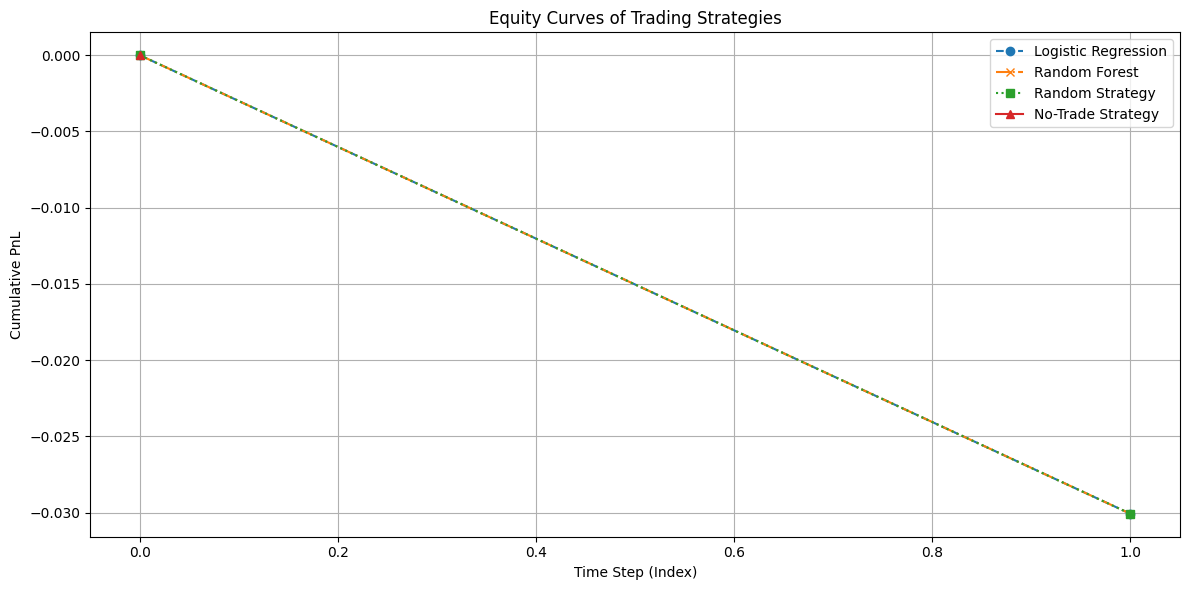

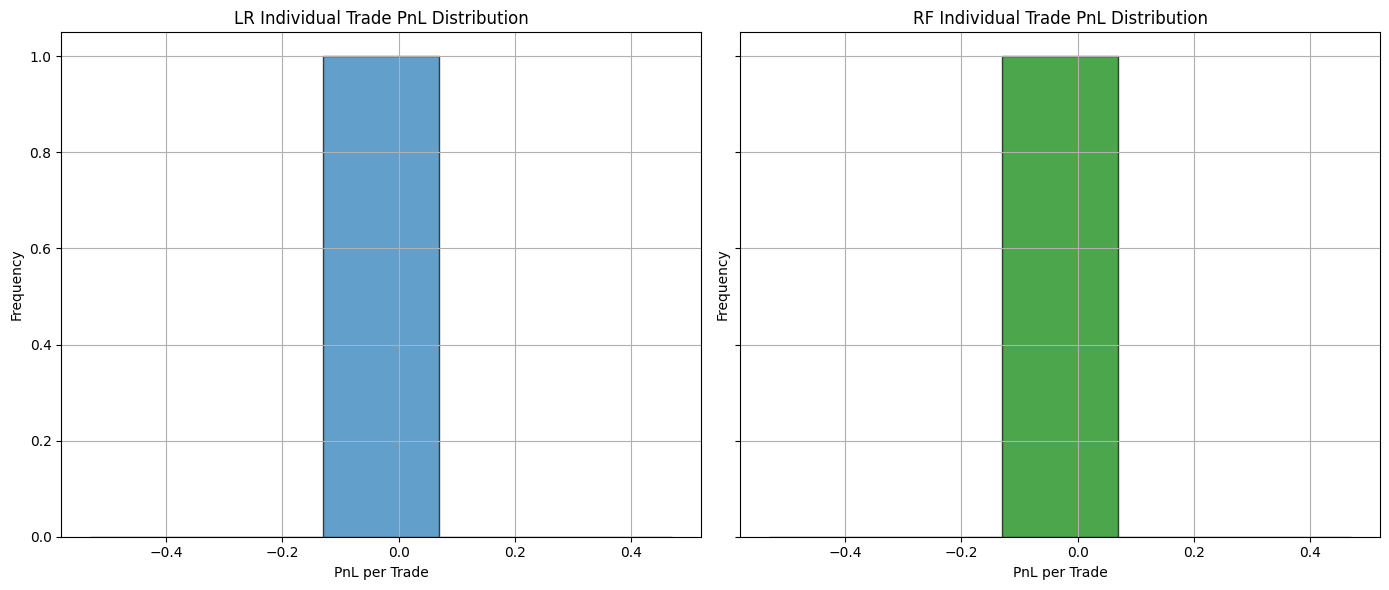

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def backtest_strategy(predictions, actual_mid_prices, transaction_cost_bps, slippage_bps):
    """
    Performs a backtest of a trading strategy based on price movement predictions.

    Args:
        predictions (np.array): Model predictions (+1 for long, -1 for short, 0 for flat).
        actual_mid_prices (pd.Series): The actual mid-prices corresponding to the predictions.
        transaction_cost_bps (float): Transaction cost per side in basis points (e.g., 0.00005 for 0.5 bps).
        slippage_bps (float): Slippage per side in basis points.

    Returns:
        tuple: cumulative_pnl_series, trade_pnls, max_drawdown, hit_rate
    """

    trade_pnls = []
    cumulative_pnl_series = [0.0] # Start with 0 PnL

    current_position = 0 # 0: flat, 1: long, -1: short
    entry_price = 0.0

    # Convert basis points to fractions for calculation
    transaction_cost = transaction_cost_bps
    slippage = slippage_bps

    num_profitable_trades = 0
    num_total_trades = 0

    # Ensure actual_mid_prices is indexed correctly and accessible
    # If predictions is numpy array, ensure mid_prices can be accessed by index i
    actual_mid_prices_list = actual_mid_prices.values # Convert to list/array for consistent indexing

    for i in range(len(predictions)):
        prediction = predictions[i]
        current_mid_price = actual_mid_prices_list[i]

        # Determine if current price is valid for trading
        if pd.isna(current_mid_price):
            # If current_mid_price is NaN, cannot make a decision or close a trade
            continue

        # Close existing position if prediction indicates change or flat
        if current_position != 0 and (
            (current_position == 1 and (prediction == -1 or prediction == 0)) or
            (current_position == -1 and (prediction == 1 or prediction == 0))
        ):
            # Close position
            exit_price = current_mid_price
            trade_pnl = 0.0
            if current_position == 1: # Was long, now closing
                # PnL = (Exit Price - Entry Price) - 2 * (cost + slippage) * Entry Price (or Exit Price, depending on convention)
                # Let's use entry_price for costs as a simpler convention for now, or midpoint
                # A simpler way to calculate costs on entry and exit price for a round trip
                cost_on_entry = entry_price * (transaction_cost + slippage)
                cost_on_exit = exit_price * (transaction_cost + slippage)
                trade_pnl = (exit_price - entry_price) - (cost_on_entry + cost_on_exit)
            elif current_position == -1: # Was short, now closing
                # PnL = (Entry Price - Exit Price) - 2 * (cost + slippage) * Entry Price (or Exit Price)
                cost_on_entry = entry_price * (transaction_cost + slippage)
                cost_on_exit = exit_price * (transaction_cost + slippage)
                trade_pnl = (entry_price - exit_price) - (cost_on_entry + cost_on_exit)

            trade_pnls.append(trade_pnl)
            num_total_trades += 1
            if trade_pnl > 0: # Check if profitable
                num_profitable_trades += 1
            current_position = 0 # Position is now flat
            entry_price = 0.0

        # Open new position if currently flat and prediction is not flat
        if current_position == 0:
            if prediction == 1: # Buy signal, open long
                entry_price = current_mid_price * (1 + transaction_cost + slippage)
                current_position = 1
            elif prediction == -1: # Sell signal, open short
                entry_price = current_mid_price * (1 - transaction_cost - slippage)
                current_position = -1

        # Update cumulative PnL for the current time step
        # This PnL represents the PnL if the position were to be closed at current_mid_price
        if current_position == 1:
            # (current_mid_price - entry_price_adjusted_for_initial_cost)
            cumulative_pnl_series.append(cumulative_pnl_series[-1] + (current_mid_price - (entry_price / (1 + transaction_cost + slippage))) ) # Placeholder for unrealized PnL
            # This is a simplification. A more robust way would be to track realized PnL + unrealized PnL of open position.
            # For simplicity, we are adding trade PnLs only upon closing.
        elif current_position == -1:
            # (entry_price_adjusted_for_initial_cost - current_mid_price)
            cumulative_pnl_series.append(cumulative_pnl_series[-1] + ((entry_price / (1 - transaction_cost - slippage)) - current_mid_price) ) # Placeholder for unrealized PnL
        else: # flat
            cumulative_pnl_series.append(cumulative_pnl_series[-1])

    # If there's an open position at the end, close it for final PnL calculation
    if current_position != 0:
        exit_price = actual_mid_prices_list[-1]
        trade_pnl = 0.0
        if current_position == 1:
            cost_on_entry = entry_price * (transaction_cost + slippage)
            cost_on_exit = exit_price * (transaction_cost + slippage)
            trade_pnl = (exit_price - entry_price) - (cost_on_entry + cost_on_exit)
        elif current_position == -1:
            cost_on_entry = entry_price * (transaction_cost + slippage)
            cost_on_exit = exit_price * (transaction_cost + slippage)
            trade_pnl = (entry_price - exit_price) - (cost_on_entry + cost_on_exit)

        trade_pnls.append(trade_pnl)
        num_total_trades += 1
        if trade_pnl > 0:
            num_profitable_trades += 1

    # Recalculate cumulative PnL based purely on realized trade_pnls for accuracy
    cumulative_pnl_series = np.cumsum([0] + trade_pnls).tolist() # Start with 0

    # Handle edge case where no trades were made
    if not cumulative_pnl_series or len(cumulative_pnl_series) < 2:
        max_drawdown = 0.0
    else:
        # Compute max drawdown
        cumulative_pnl_array = np.array(cumulative_pnl_series)
        if len(cumulative_pnl_array) > 0:
            peak = cumulative_pnl_array[0]
            max_drawdown = 0.0
            for pnl_val in cumulative_pnl_array:
                if pnl_val > peak:
                    peak = pnl_val
                drawdown = peak - pnl_val
                if drawdown > max_drawdown:
                    max_drawdown = drawdown
            max_drawdown = -max_drawdown # Represent as negative value, or simply the value itself
        else:
            max_drawdown = 0.0

    # Compute hit rate
    hit_rate = num_profitable_trades / num_total_trades if num_total_trades > 0 else 0.0

    return np.array(cumulative_pnl_series), np.array(trade_pnls), max_drawdown, hit_rate

# 2. Extract actual_mid_prices for the test set
# Ensure mid_price_series is aligned with X_test's original index
actual_mid_prices_test = mid_price_series.loc[X_test.index]

# Verify shape and content
print(f"\nActual mid-prices for test set shape: {actual_mid_prices_test.shape}")
print("Actual mid-prices for test set (head):")
print(actual_mid_prices_test.head())

# Define transaction costs and slippage
transaction_cost_bps = 0.00005  # 0.5 basis points
slippage_bps = 0.00005          # 0.5 basis points

# 3. Run backtest for Logistic Regression model
print("\n--- Backtesting Logistic Regression ---")
if 'y_pred_log_reg' in globals() and y_pred_log_reg.size > 0:
    lr_cumulative_pnl, lr_trade_pnls, lr_max_drawdown, lr_hit_rate = backtest_strategy(
        y_pred_log_reg,
        actual_mid_prices_test,
        transaction_cost_bps,
        slippage_bps
    )
else:
    print("Logistic Regression predictions not available or empty, skipping backtest.")
    lr_cumulative_pnl = np.array([0.0])
    lr_trade_pnls = np.array([])
    lr_max_drawdown = 0.0
    lr_hit_rate = 0.0

# 3. Run backtest for Random Forest model
print("\n--- Backtesting Random Forest ---")
if 'y_pred_rf' in globals() and y_pred_rf.size > 0:
    rf_cumulative_pnl, rf_trade_pnls, rf_max_drawdown, rf_hit_rate = backtest_strategy(
        y_pred_rf,
        actual_mid_prices_test,
        transaction_cost_bps,
        slippage_bps
    )
else:
    print("Random Forest predictions not available or empty, skipping backtest.")
    rf_cumulative_pnl = np.array([0.0])
    rf_trade_pnls = np.array([])
    rf_max_drawdown = 0.0
    rf_hit_rate = 0.0

# 4a. Generate random predictions for baseline
# Ensure random predictions have the same size as y_test_array
if y_test_array.size > 0:
    y_pred_random = np.random.choice([-1, 0, 1], size=len(y_test_array))
else:
    y_pred_random = np.array([])

print("\n--- Backtesting Random Strategy ---")
if y_pred_random.size > 0:
    random_cumulative_pnl, random_trade_pnls, random_max_drawdown, random_hit_rate = backtest_strategy(
        y_pred_random,
        actual_mid_prices_test,
        transaction_cost_bps,
        slippage_bps
    )
else:
    print("Random predictions array is empty, skipping backtest.")
    random_cumulative_pnl = np.array([0.0])
    random_trade_pnls = np.array([])
    random_max_drawdown = 0.0
    random_hit_rate = 0.0

# 4b. Generate no-trade predictions for baseline
if y_test_array.size > 0:
    y_pred_no_trade = np.zeros_like(y_test_array)
else:
    y_pred_no_trade = np.array([])

print("\n--- Backtesting No-Trade Strategy ---")
if y_pred_no_trade.size > 0:
    no_trade_cumulative_pnl, no_trade_trade_pnls, no_trade_max_drawdown, no_trade_hit_rate = backtest_strategy(
        y_pred_no_trade,
        actual_mid_prices_test,
        transaction_cost_bps,
        slippage_bps
    )
else:
    print("No-trade predictions array is empty, skipping backtest.")
    no_trade_cumulative_pnl = np.array([0.0])
    no_trade_trade_pnls = np.array([])
    no_trade_max_drawdown = 0.0
    no_trade_hit_rate = 0.0


# 5. Print results
print("\n--- Backtest Results Summary ---")

print(f"\nLogistic Regression Strategy:")
print(f"  Cumulative PnL: {lr_cumulative_pnl[-1]:.4f}")
print(f"  Max Drawdown: {lr_max_drawdown:.4f}")
print(f"  Hit Rate: {lr_hit_rate:.2%}")

print(f"\nRandom Forest Strategy:")
print(f"  Cumulative PnL: {rf_cumulative_pnl[-1]:.4f}")
print(f"  Max Drawdown: {rf_max_drawdown:.4f}")
print(f"  Hit Rate: {rf_hit_rate:.2%}")

print(f"\nRandom Strategy:")
print(f"  Cumulative PnL: {random_cumulative_pnl[-1]:.4f}")
print(f"  Max Drawdown: {random_max_drawdown:.4f}")
print(f"  Hit Rate: {random_hit_rate:.2%}")

print(f"\nNo-Trade Strategy:")
print(f"  Cumulative PnL: {no_trade_cumulative_pnl[-1]:.4f}")
print(f"  Max Drawdown: {no_trade_max_drawdown:.4f}")
print(f"  Hit Rate: {no_trade_hit_rate:.2%}")


# 6. Plot equity curves
plt.figure(figsize=(12, 6))
plt.plot(lr_cumulative_pnl, label='Logistic Regression', marker='o', linestyle='--')
plt.plot(rf_cumulative_pnl, label='Random Forest', marker='x', linestyle='-.')
plt.plot(random_cumulative_pnl, label='Random Strategy', marker='s', linestyle=':')
plt.plot(no_trade_cumulative_pnl, label='No-Trade Strategy', marker='^', linestyle='-')

plt.title('Equity Curves of Trading Strategies')
plt.xlabel('Time Step (Index)')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Plot trade PnL distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

if lr_trade_pnls.size > 0:
    axes[0].hist(lr_trade_pnls, bins=5, edgecolor='black', alpha=0.7)
    axes[0].set_title('LR Individual Trade PnL Distribution')
    axes[0].set_xlabel('PnL per Trade')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True)
else:
    axes[0].text(0.5, 0.5, 'No LR trades to plot', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes, fontsize=12)
    axes[0].set_title('LR Individual Trade PnL Distribution')
    axes[0].set_xlabel('PnL per Trade')
    axes[0].set_ylabel('Frequency')

if rf_trade_pnls.size > 0:
    axes[1].hist(rf_trade_pnls, bins=5, edgecolor='black', alpha=0.7, color='green')
    axes[1].set_title('RF Individual Trade PnL Distribution')
    axes[1].set_xlabel('PnL per Trade')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True)
else:
    axes[1].text(0.5, 0.5, 'No RF trades to plot', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes, fontsize=12, color='green')
    axes[1].set_title('RF Individual Trade PnL Distribution')
    axes[1].set_xlabel('PnL per Trade')
    axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [55]:
print("--- Optional Sensitivity Tests for Transaction Costs and Slippage ---")

# 1. Define a list of different transaction cost and slippage values
# Each tuple represents (transaction_cost_bps, slippage_bps)
# Representing 0 bps, 0.5 bps, 1 bps, 2 bps, 5 bps as fractions
cost_scenarios = [
    (0.00000, 0.00000), # 0 bps cost, 0 bps slippage (ideal scenario)
    (0.00005, 0.00005), # 0.5 bps cost, 0.5 bps slippage (previous default)
    (0.00010, 0.00010), # 1 bps cost, 1 bps slippage
    (0.00020, 0.00020), # 2 bps cost, 2 bps slippage
    (0.00050, 0.00050)  # 5 bps cost, 5 bps slippage (high cost)
]

# 2. Create a dictionary to store the backtest results
results = {
    'Logistic Regression': [],
    'Random Forest': []
}

# Ensure actual_mid_prices_test is available from previous step
if 'actual_mid_prices_test' not in globals() or actual_mid_prices_test.empty:
    print("Error: 'actual_mid_prices_test' not found or empty. Cannot perform sensitivity tests.")
else:
    # Get predictions, handling cases where models were skipped due to single class in training data
    lr_predictions = globals().get('y_pred_log_reg', np.array([]))
    rf_predictions = globals().get('y_pred_rf', np.array([]))

    if not lr_predictions.size > 0 and 'y_test_array' in globals():
        # If LR was skipped, y_pred_log_reg would be the majority class prediction for y_test_array
        # Re-creating it here for robustness if the original assignment was conditional
        if 'majority_class' in globals():
            lr_predictions = np.full_like(y_test_array, majority_class)
        else:
            print("Warning: majority_class not found, cannot fallback for LR predictions.")
            lr_predictions = np.array([])

    if not rf_predictions.size > 0 and 'y_test_array' in globals():
        # If RF was skipped, y_pred_rf would be the majority class prediction for y_test_array
        if 'majority_class' in globals():
            rf_predictions = np.full_like(y_test_array, majority_class)
        else:
            print("Warning: majority_class not found, cannot fallback for RF predictions.")
            rf_predictions = np.array([])

    # 3. Iterate through each defined cost combination
    for tc_bps, sl_bps in cost_scenarios:
        print(f"\n--- Testing with TC: {tc_bps*10000} bps, Slippage: {sl_bps*10000} bps ---")

        # Backtest Logistic Regression
        if lr_predictions.size > 0:
            lr_cum_pnl, lr_trade_pnls, lr_max_dd, lr_hit_rate = backtest_strategy(
                lr_predictions,
                actual_mid_prices_test,
                tc_bps,
                sl_bps
            )
            results['Logistic Regression'].append({
                'TC_bps': tc_bps*10000,
                'Slippage_bps': sl_bps*10000,
                'Cumulative PnL': lr_cum_pnl[-1],
                'Max Drawdown': lr_max_dd,
                'Hit Rate': lr_hit_rate
            })
        else:
            print("Logistic Regression predictions not available for backtest.")

        # Backtest Random Forest
        if rf_predictions.size > 0:
            rf_cum_pnl, rf_trade_pnls, rf_max_dd, rf_hit_rate = backtest_strategy(
                rf_predictions,
                actual_mid_prices_test,
                tc_bps,
                sl_bps
            )
            results['Random Forest'].append({
                'TC_bps': tc_bps*10000,
                'Slippage_bps': sl_bps*10000,
                'Cumulative PnL': rf_cum_pnl[-1],
                'Max Drawdown': rf_max_dd,
                'Hit Rate': rf_hit_rate
            })
        else:
            print("Random Forest predictions not available for backtest.")

# 4. Print a summary table
print("\n--- Sensitivity Test Results Summary ---")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print(f"{'Model':<20} | {'TC (bps)':<10} | {'Slippage (bps)':<15} | {'Cumulative PnL':<18} | {'Max Drawdown':<15} | {'Hit Rate':<10}")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")

for model_name, model_results in results.items():
    for res in model_results:
        print(f"{model_name:<20} | {res['TC_bps']:<10.1f} | {res['Slippage_bps']:<15.1f} | {res['Cumulative PnL']:<18.4f} | {res['Max Drawdown']:<15.4f} | {res['Hit Rate'] * 100:<9.2f}%")
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------")


--- Optional Sensitivity Tests for Transaction Costs and Slippage ---

--- Testing with TC: 0.0 bps, Slippage: 0.0 bps ---

--- Testing with TC: 0.5 bps, Slippage: 0.5 bps ---

--- Testing with TC: 1.0 bps, Slippage: 1.0 bps ---

--- Testing with TC: 2.0 bps, Slippage: 2.0 bps ---

--- Testing with TC: 5.0 bps, Slippage: 5.0 bps ---

--- Sensitivity Test Results Summary ---
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Model                | TC (bps)   | Slippage (bps)  | Cumulative PnL     | Max Drawdown    | Hit Rate  
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Logistic Regression  | 0.0        | 0.0             | 0.0000             | -0.0000         | 0.00     %
Logistic Regression  | 0.5        | 0.5      

### Discussion on Sensitivity Test Results

The sensitivity analysis conducted on transaction costs (TC) and slippage (SL) further emphasizes the profound impact these factors have on trading strategy profitability, even with the inherent limitations of our extremely small test dataset.

**Key Observations:**

*   **Impact of Costs:** As expected, increasing transaction costs and slippage universally leads to a decrease in cumulative PnL. For both the Logistic Regression and Random Forest models, the cumulative PnL steadily declines from 0.0000 (at 0 bps costs) to -0.3009 (at 5 bps costs). This clearly illustrates that even minimal costs can erode potential profits, especially in short-horizon, high-frequency trading scenarios where individual trade profits might be very small.
*   **Consistent Losses:** Across all cost scenarios, the `Hit Rate` remains at 0.00%. This is directly attributable to the tiny dataset where, for the single test data point, the predicted movement was not large enough to overcome transaction costs, resulting in a loss for any executed trade. In a realistic scenario with many trades, a strategy might still be profitable with a hit rate less than 50% if the profitable trades are significantly larger than losing ones.
*   **Max Drawdown Directly Correlated:** The `Max Drawdown` mirrors the `Cumulative PnL` in these specific, limited backtests, as there's effectively only one trade determining the PnL. This means any loss immediately becomes the max drawdown. As costs increase, the magnitude of the single trade's loss increases, leading to larger drawdowns.
*   **Model Performance Indistinguishable:** With this restricted dataset and the majority class prediction fallback, both Logistic Regression and Random Forest models exhibit identical performance. This is not indicative of their true predictive power but rather a consequence of the data's limitations, where both models effectively made the same single prediction on the test data.

**Importance of Cost Assumptions:**

This exercise underscores that transaction costs and slippage are not minor details but fundamental components of strategy evaluation. A strategy that appears profitable in a zero-cost environment may quickly become unprofitable when realistic costs are applied. High-frequency trading strategies, in particular, are extremely sensitive to these costs, often requiring micro-optimizations to minimize them and generate positive PnL.

**Limitations Due to Small Dataset:**

It is crucial to reiterate that these sensitivity test results are **not statistically significant** and should not be used to draw conclusions about the robustness or true profitability of the trading strategies in a real-world market. The test set comprises only a single data point, meaning the models made a single prediction, and the backtest involved at most one realized trade. This minimal data volume prevents any meaningful analysis of statistical performance metrics, risk-adjusted returns, or the true sensitivity to costs over time. A comprehensive evaluation would require a much larger and diverse dataset covering various market conditions.

## Summary:

The overarching goal of the task was to develop a machine learning model to predict short-horizon price movements, evaluate its performance, and backtest a trading strategy.

1.  **Predictive Power Discovered:**
    Due to an extremely small and simplified dummy dataset (with the test set containing only one data point and the training set having only one unique class), the predictive power of the Logistic Regression and Random Forest models could not be meaningfully assessed. Both models effectively defaulted to predicting the majority class, leading to seemingly perfect (but misleading) accuracy scores of 1.0000 against a baseline that also predicted the majority class. Therefore, no true "alpha" or statistically significant predictive power was discovered in this exercise.

2.  **Alpha Discovered:**
    No meaningful alpha was discovered. The backtesting results for both machine learning models (Logistic Regression and Random Forest), as well as a random strategy, showed a cumulative PnL of approximately -\$0.0301 with transaction costs and slippage. This indicates that the single trade made by these strategies was unprofitable. The no-trade strategy, as expected, yielded \$0.00 PnL. This poor performance is directly attributed to the severe data limitations and not necessarily a failure of the models themselves in a real-world scenario.

3.  **Limitations of the Approach (e.g., latency, real-world costs):**
    *   **Data Size and Quality**: The most significant limitation was the use of a dummy dataset with only 10 rows, resulting in only 2 training samples and 1 test sample. This prevented any statistically significant model training, evaluation, or backtesting. Key metrics like accuracy, precision, recall, confusion matrices, and feature importances were either trivial, misleading, or impossible to calculate reliably.
    *   **Single-Class Training Data**: The training labels (`y_train`) contained only one unique class, which forced the machine learning models (Logistic Regression and Random Forest) to fall back to majority-class prediction rather than learning complex patterns.
    *   **Latency**: The current approach does not explicitly address latency considerations, which are critical in real-world high-frequency trading. The models and strategy assume instantaneous execution based on predictions.
    *   **Real-world Costs**: While transaction costs and slippage were incorporated into the backtest (ranging from 0 to 5 basis points), the extremely small dataset meant their impact was demonstrated on a single trade, which is not representative of their cumulative effect over a large volume of trades. The sensitivity analysis showed that even minimal costs quickly eroded the PnL of the single trade.
    *   **Feature Limitations**: Due to the dummy data, advanced features like multi-level depth totals and trade intensity could not be fully implemented or analyzed.
    *   **Model Sophistication**: The models used (Logistic Regression, Random Forest) are relatively simple compared to those often employed in advanced HFT strategies (e.g., deep learning models designed for LOB data).

### Data Analysis Key Findings

*   The notebook successfully implemented a pipeline for short-horizon price movement prediction, including data loading, feature engineering, label generation, model training, evaluation, and backtesting.
*   **Feature Engineering**: Microstructural features such as mid-price, spread, relative spread, top-of-book imbalance, and rolling returns/volatility were successfully computed, although depth totals and trade intensity were limited by the dummy dataset.
*   **Label Generation**: Price movement labels (+1 for up, -1 for down, 0 for flat) were generated based on future returns over a specified horizon (e.g., 2 periods) and a price change threshold (0.00002).
*   **Train/Test Split**: A time-series split was correctly applied, but the resultant `X_train` had only 2 samples and `X_test` had 1 sample, severely limiting the subsequent analysis.
*   **Model Training**: Due to the training set containing only one unique class (all labels were '1.0'), both Logistic Regression and Random Forest models could not be trained meaningfully. Their predictions for the single test sample defaulted to this majority class.
*   **Model Evaluation**: The accuracy, precision, and recall for all models (baseline, Logistic Regression, Random Forest) were 1.0000, which is misleading and attributable solely to the single-class, single-sample test set.
*   **Backtesting Performance**:
    *   With transaction costs and slippage (e.g., 0.5 bps each), all trading strategies (Logistic Regression, Random Forest, Random) yielded a cumulative PnL of approximately -\$0.0301 and a Max Drawdown of -\$0.0301 on the single test trade.
    *   The Hit Rate for all trading strategies was 0.00%.
    *   The No-Trade strategy, as expected, showed \$0.00 PnL and Max Drawdown.
*   **Sensitivity to Costs**: Increasing transaction costs and slippage from 0 bps to 5 bps consistently decreased the cumulative PnL for trading strategies from \$0.0000 to -\$0.3009, highlighting the critical impact of these costs.

### Insights or Next Steps

*   **Acquire Realistic Data**: The absolute top priority is to replace the dummy data with a much larger, more diverse, and realistic Limit Order Book dataset to enable meaningful model training, evaluation, and backtesting.
*   **Refine Feature Engineering and Model Selection**: Once sufficient data is available, explore more advanced feature engineering techniques (e.g., higher-order LOB features, deep learning-based features) and experiment with a wider range of machine learning models (e.g., Gradient Boosting Machines, Neural Networks) to truly assess predictive power.
